In [1]:
import keras
from keras import layers

# This is the size of our encoded representations
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# This is our input image
input_img = keras.Input(shape=(784,))
# "encoded" is the encoded representation of the input
encoded = layers.Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = layers.Dense(784, activation='sigmoid')(encoded)

# This model maps an input to its reconstruction
autoencoder = keras.Model(input_img, decoded)

2023-07-30 20:27:48.825865: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-30 20:27:48.853363: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-30 20:27:48.854985: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-30 20:27:49.428041: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# This model maps an input to its encoded representation
encoder = keras.Model(input_img, encoded)

In [3]:
# This is our encoded (32-dimensional) input
encoded_input = keras.Input(shape=(encoding_dim,))
# Retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# Create the decoder model
decoder = keras.Model(encoded_input, decoder_layer(encoded_input))

In [4]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [5]:
from keras.datasets import mnist
import numpy as np
(x_train, _), (x_test, _) = mnist.load_data()

In [6]:
x_train.shape

(60000, 28, 28)

In [7]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


In [8]:
hist = autoencoder.fit(x_train, x_train,
                        epochs=50,
                        batch_size=256,
                        shuffle=True,
                        validation_data=(x_test, x_test))

Epoch 1/50
235/235 [==============================] - 2s 5ms/step - loss: 0.2791 - val_loss: 0.1922
Epoch 2/50
235/235 [==============================] - 1s 5ms/step - loss: 0.1730 - val_loss: 0.1544
Epoch 3/50
235/235 [==============================] - 1s 5ms/step - loss: 0.1448 - val_loss: 0.1339
Epoch 4/50
235/235 [==============================] - 1s 5ms/step - loss: 0.1285 - val_loss: 0.1210
Epoch 5/50
235/235 [==============================] - 1s 4ms/step - loss: 0.1183 - val_loss: 0.1130
Epoch 6/50
235/235 [==============================] - 1s 4ms/step - loss: 0.1113 - val_loss: 0.1070
Epoch 7/50
235/235 [==============================] - 1s 5ms/step - loss: 0.1062 - val_loss: 0.1027
Epoch 8/50
235/235 [==============================] - 1s 4ms/step - loss: 0.1025 - val_loss: 0.0997
Epoch 9/50
235/235 [==============================] - 1s 4ms/step - loss: 0.0997 - val_loss: 0.0973
Epoch 10/50
235/235 [==============================] - 1s 4ms/step - loss: 0.0977 - val_loss: 0.0957

In [9]:
# Encode and decode some digits
# Note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

313/313 [==============================] - 0s 766us/step


In [11]:
x_test.shape

(10000, 784)

In [12]:
encoded_imgs.shape

(10000, 32)

In [13]:
decoded_imgs.shape

(10000, 784)

In [19]:
np.ceil(10_000/313)

32.0

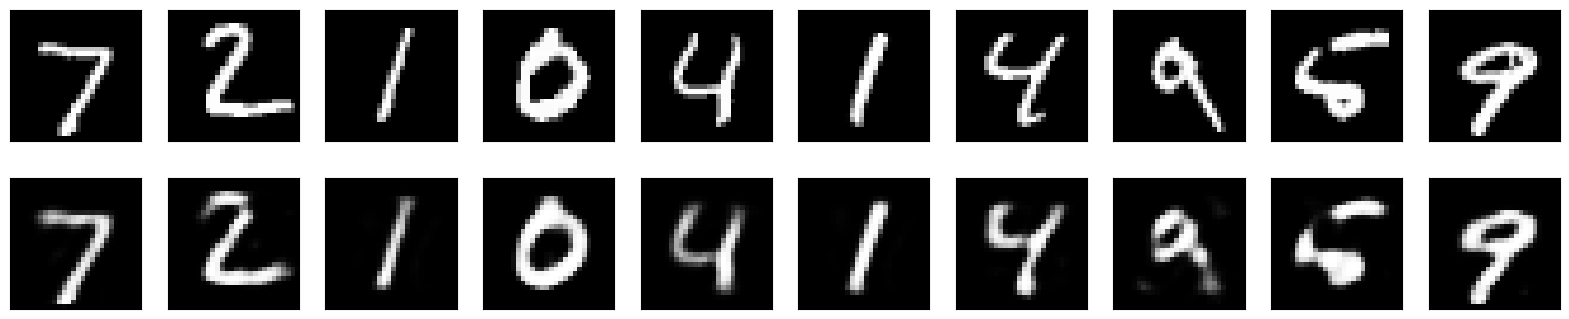

In [10]:
# Use Matplotlib (don't ask)
import matplotlib.pyplot as plt

n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()